# Librairies

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Représentation graphique

In [58]:
# Import et concaténation des deux fichiers source
path = "../Data/"
df_source1 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset.csv")
df_source2 = pd.read_csv(path + "Sleep_health_and_lifestyle_dataset_part_2.csv")
df = pd.concat([df_source1, df_source2])

# Person ID 374 est un doublon
df.drop(index=373, inplace=True)

# On retire l'ID du sujet qui ne nous sera pas utile
df.drop(columns="Person ID", inplace=True)

# On retire les doublons
df.drop_duplicates(inplace=True)

# On recréé l'index
df.index = np.arange(1,len(df)+1,1)

In [71]:
# Modification des noms de colonne, on supprime les espaces
mapper = {
    "Sleep Duration" : "SleepDuration",
    "Quality of Sleep" : "QualitySleep",
    "Physical Activity Level" : "PhysicalActivityLevel",
    "Stress Level" : "StressLevel",
    "BMI Category" : "BMI_Category",
    "Blood Pressure" : "BloodPressure",
    "Heart Rate" : "HeartRate",
    "Daily Steps" : "DailySteps",
    "Sleep Disorder" : "SleepDisorder"
}
df.rename(columns=mapper, inplace=True)

# On rectifie le type des variables (par défaut importées comme object)
new_types = {
    "Gender" : "string",
    "Occupation" : "string",
    "BMI_Category" : "string",
    "BloodPressure" : "string",
    "SleepDisorder" : "string"
}
df = df.astype(new_types)

# On a deux BMI_Category normales : "Normal Weight" et "Normal"
# On transforme les "Normal Weight" par "Normal"
df.replace("Normal Weight", "Normal", inplace=True)


In [60]:
# On sait qu'on n'a aucune valeur manquante pour SleepDisorder (None dans le fichier source)
# On crée une nouvelle catégorie pour les personnes sans trouble du sommeil
df.loc[df["SleepDisorder"].isna(), "SleepDisorder"] = "Healthy"

# On vérifie qu'on n'a aucune donnée manquante par ailleurs
df.isna().sum()

Gender                   0
Age                      0
Occupation               0
SleepDuration            0
QualitySleep             0
PhysicalActivityLevel    0
StressLevel              0
BMI_Category             0
BloodPressure            0
HeartRate                0
DailySteps               0
SleepDisorder            0
dtype: int64

In [61]:
# Regroupement les classes minorées
threshold = 10

# Initialiser variables
Occupation = df["Occupation"].value_counts()
filtered_sizes_Occupation = []
other_total = 0

# Iterer la liste
for label, size in Occupation.items():
    if size < threshold:
        other_total += size
    else:
        filtered_sizes_Occupation.append(size)

# Grouper en "Other"
if other_total > 0:
    filtered_sizes_Occupation.append(other_total)
filtered_sizes_Occupation

[29, 24, 22, 15, 15, 11, 16]

([<matplotlib.patches.Wedge at 0x30ebc4740>,
 [Text(-0.18241303655662278, 1.0847697839146297, 'Healthy'),
  Text(-0.5499999256737775, -0.9526279870751434, 'Sleep Apnea'),
  Text(0.8482317592793235, -0.7003591097072301, 'Insomnia')],
 [Text(-0.09949801993997605, 0.5916926094079797, '55%'),
  Text(-0.29999995945842406, -0.5196152656773508, '23%'),
  Text(0.46267186869781274, -0.3820140598403073, '22%')])

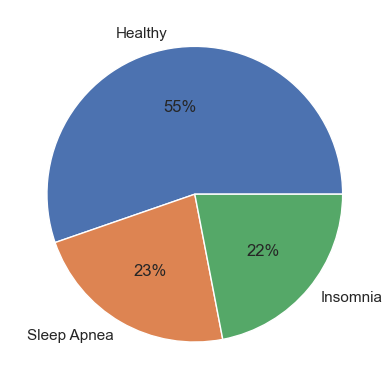

In [62]:
# Compter le nombre des valeurs distinctes des variables qualitatives
SleepDisorder = df["SleepDisorder"].value_counts()

plt.pie(SleepDisorder, labels = ["Healthy","Sleep Apnea","Insomnia"], autopct='%.0f%%') 


Text(0.5, 1.0, 'IMC')

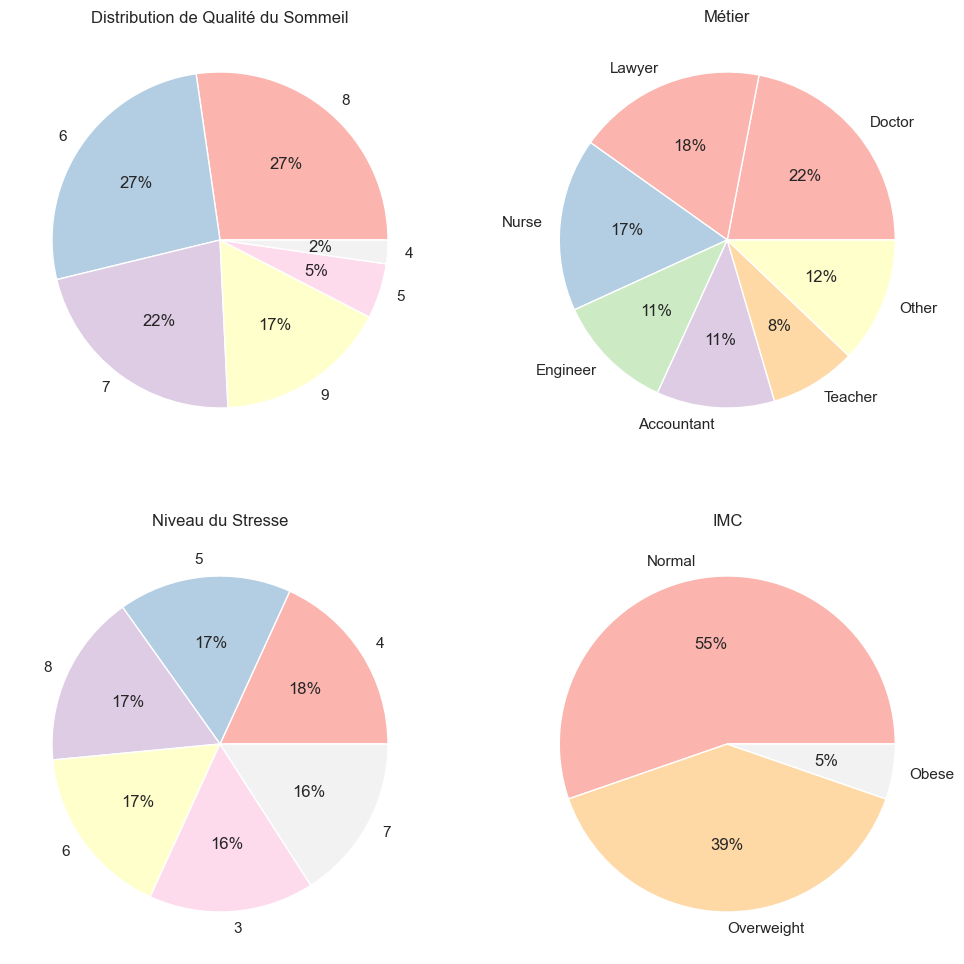

In [72]:
# Compter le nombre des valeurs distinctes des variables qualitatives
QualitySleep = df["QualitySleep"].value_counts()
Occupation = df["Occupation"].value_counts()
StressLevel = df["StressLevel"].value_counts()
BMI_Category = df["BMI_Category"].value_counts()

cmap = plt.get_cmap("Pastel1")
colors_QualitySleep = cmap(np.linspace(0, 1, len(QualitySleep)))
colors_Occupation = cmap(np.linspace(0, 1, len(Occupation)))
colors_StressLevel = cmap(np.linspace(0, 1, len(StressLevel)))
colors_BMI_Category = cmap(np.linspace(0, 1, len(BMI_Category)))

df.replace("Normal Weight", "Normal", inplace=True)

# Plotter le diagramme circulaire des variable explicatives
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].pie(QualitySleep, labels = ["8","6","7","9","5","4"], autopct='%.0f%%', colors=colors_QualitySleep)
axes[0,0].set_title("Distribution de Qualité du Sommeil")
axes[0,1].pie(filtered_sizes_Occupation, labels = ["Doctor", "Lawyer", "Nurse", "Engineer", "Accountant", "Teacher", "Other"], autopct='%.0f%%', colors=colors_Occupation)
axes[0,1].set_title("Métier") 
axes[1,0].pie(StressLevel, labels = ["4", "5", "8", "6", "3", "7"], autopct='%.0f%%', colors=colors_StressLevel)
axes[1,0].set_title("Niveau du Stresse") 
axes[1,1].pie(BMI_Category, labels = ["Normal", "Overweight", "Obese"], autopct='%.0f%%', colors=colors_BMI_Category) 
axes[1,1].set_title("IMC")

<Axes: xlabel='SleepDisorder', ylabel='StressLevel'>

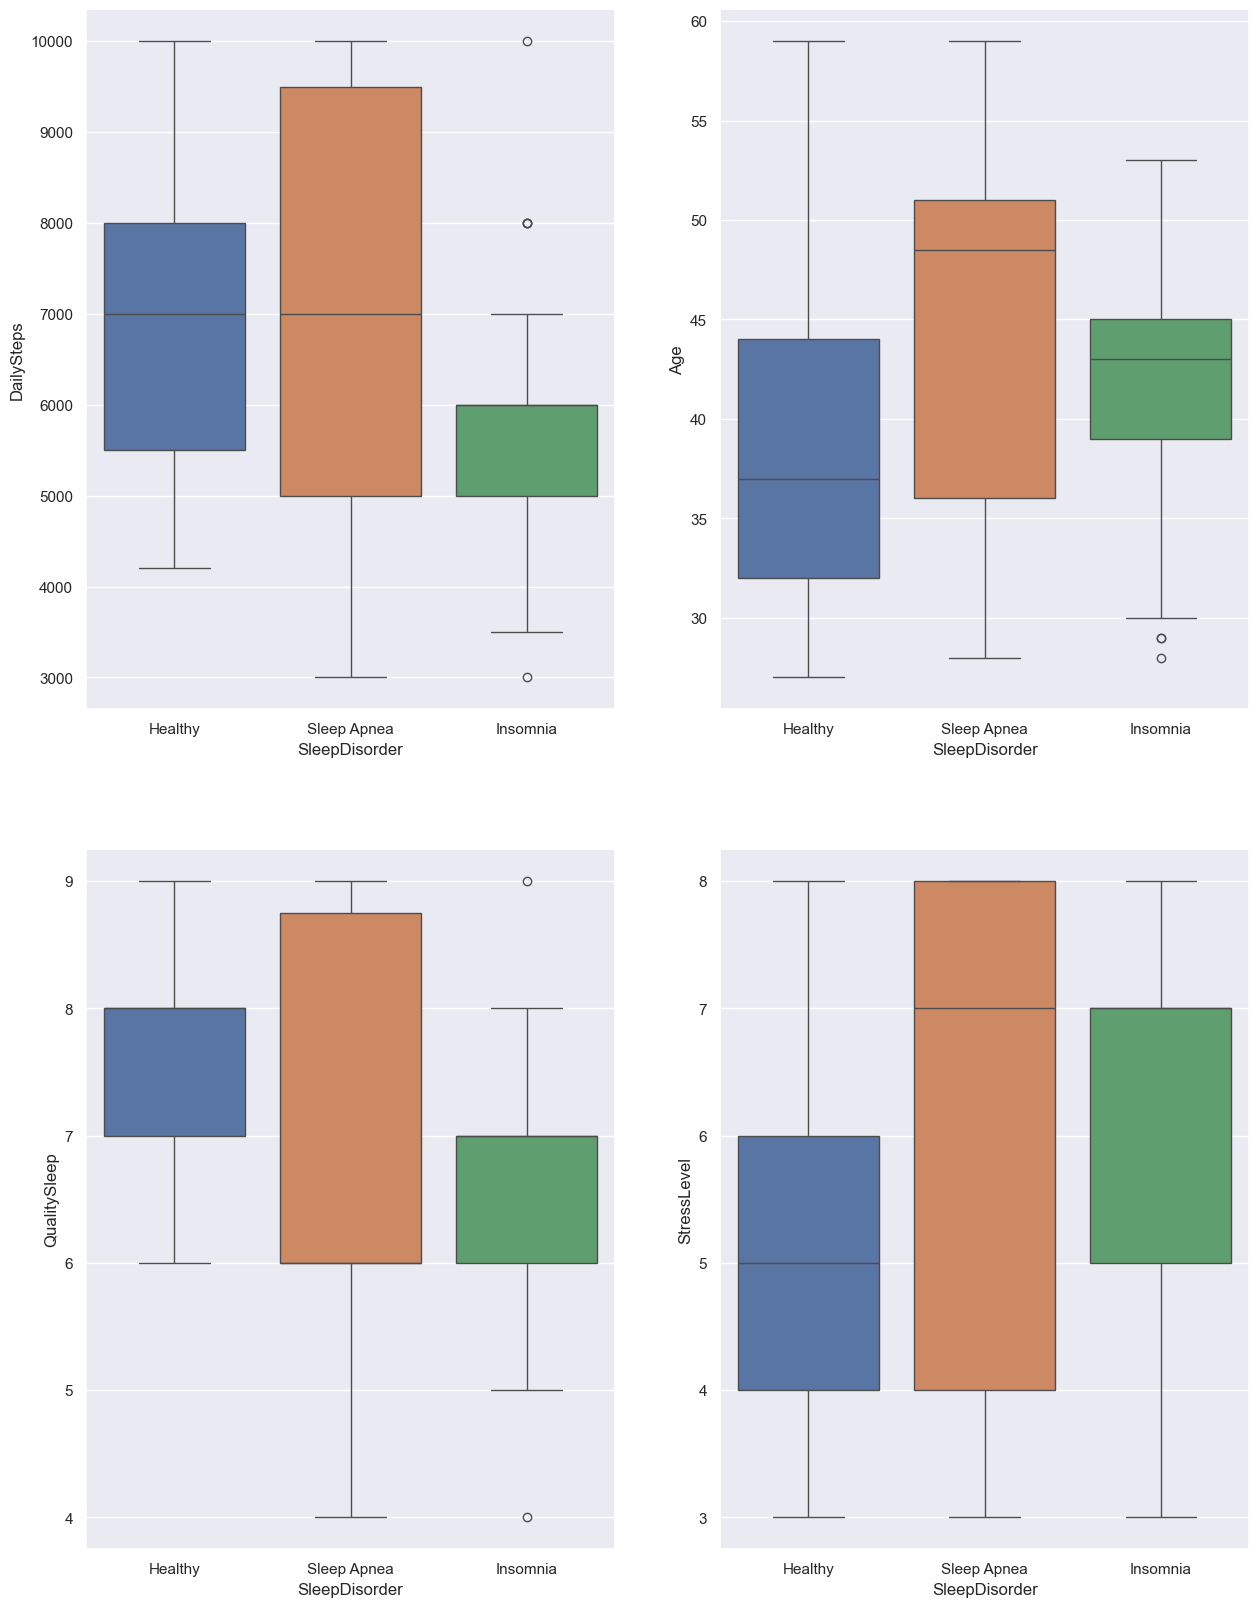

In [75]:
#BOXPLOT
sns.set_theme()

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_figheight(20)
fig.set_figwidth(15)

BMI_order = ["Normal","Overweight","Obese"]
#sns.boxplot(data = df, x = 'Gender', y = "Age",hue = "Gender",palette="Pastel1", ax=axs[0][0])
#sns.boxplot(data = df, x = 'Gender', y = "QualitySleep",hue = "Gender",palette="Pastel1", ax=axs[0][1])
#sns.boxplot(data = df, x = 'BMI_Category', y = "PhysicalActivityLevel",hue = "BMI_Category",order=BMI_order,palette="Pastel1", ax=axs[1][0]) #Important, pour montrer que les données sont cohérentes qd même
#sns.boxplot(data = df, x = 'BMI_Category', y = "QualitySleep",hue = "BMI_Category",order=BMI_order,palette="Pastel1", ax=axs[1][1]) #Important, pour montrer que les données sont cohérentes qd même
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/boxplot1")
sns.boxplot(data = df, x = 'SleepDisorder', y = "DailySteps",hue = "SleepDisorder", ax=axs[0][0]) #Important
sns.boxplot(data = df, x = 'SleepDisorder', y = "Age",hue = "SleepDisorder", ax=axs[0][1]) #Important
sns.boxplot(data = df, x = 'SleepDisorder', y = "QualitySleep",hue = "SleepDisorder", ax=axs[1][0])
sns.boxplot(data = df, x = 'SleepDisorder', y = "StressLevel",hue = "SleepDisorder", ax=axs[1][1]) #Important
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/boxplot2")

<Axes: xlabel='SleepDisorder', ylabel='Count'>

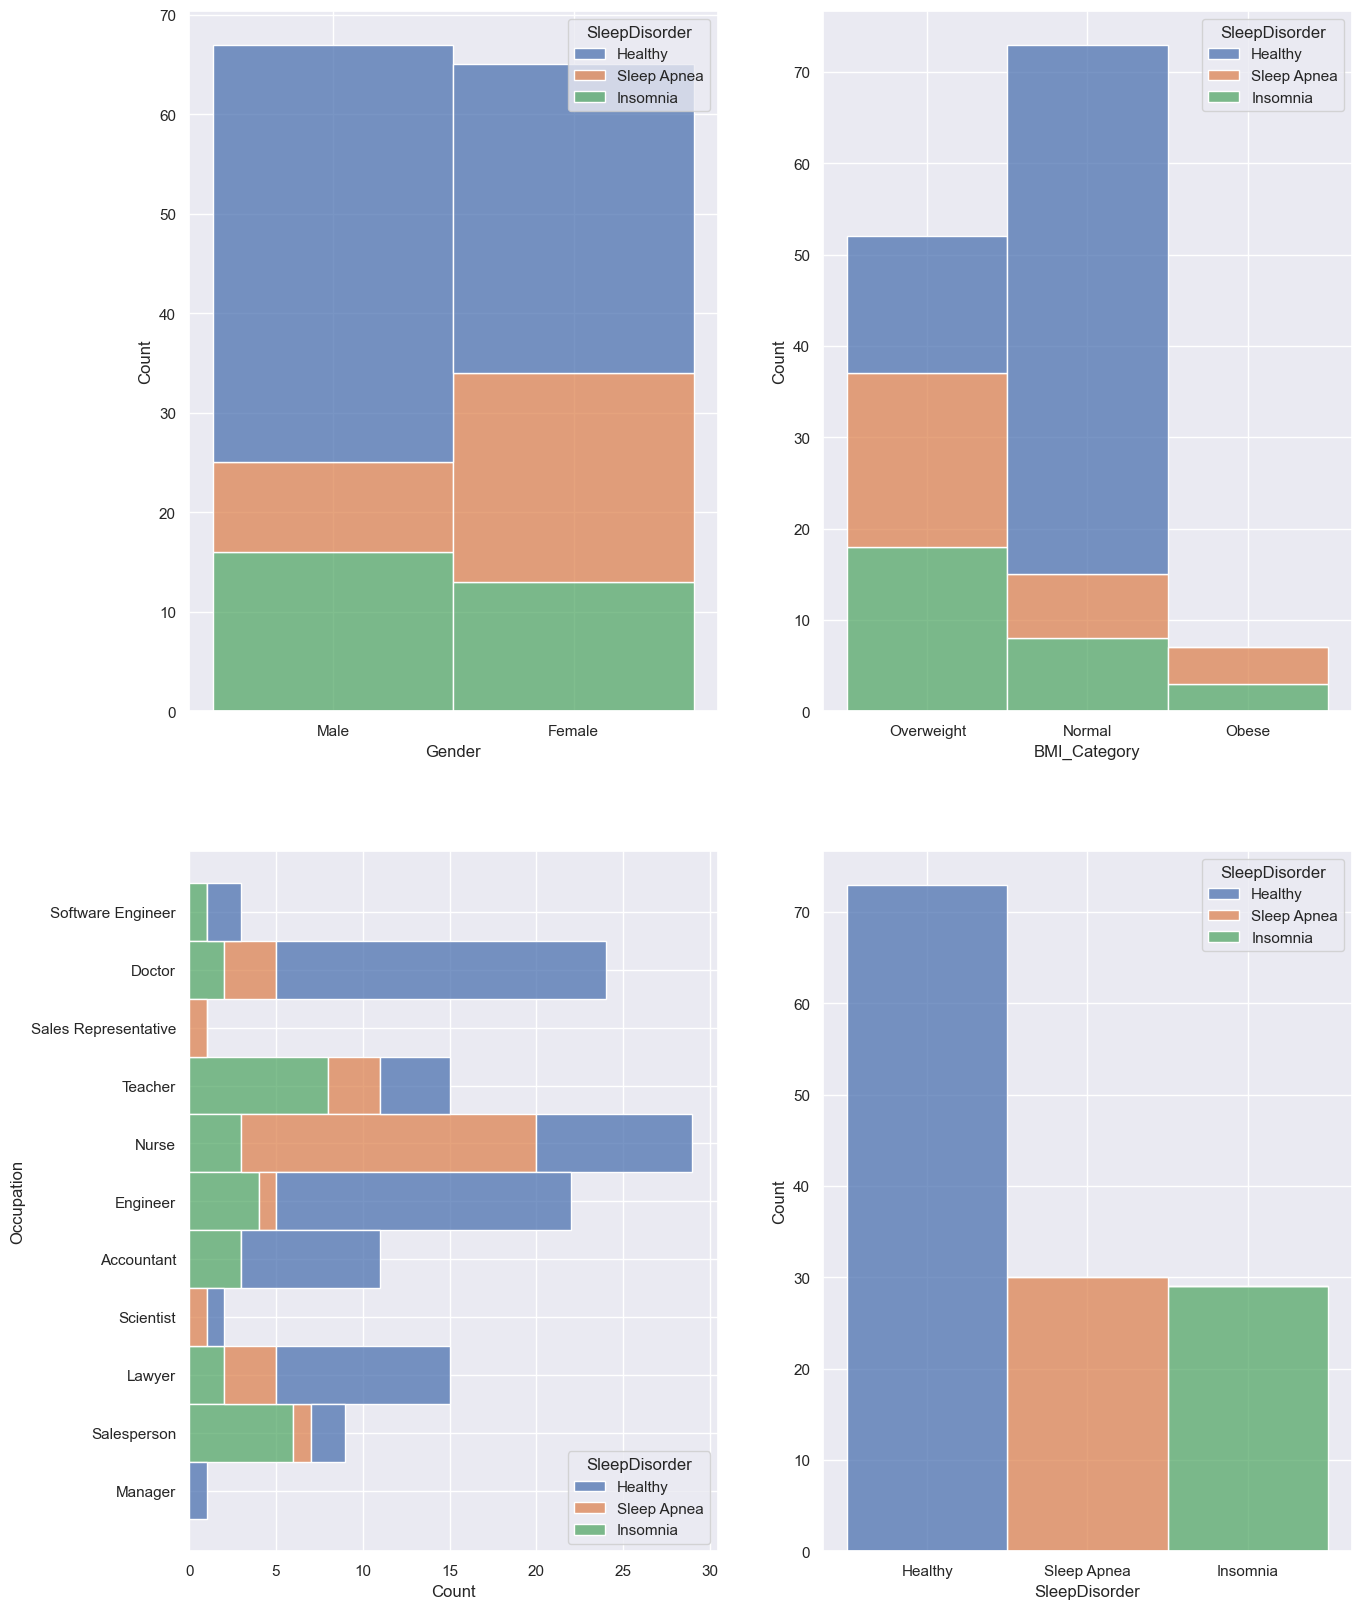

In [76]:
#HISTOGRAMMES
sns.set_theme()

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_figheight(20)
fig.set_figwidth(15)
#Histogrammes pour les variables catégorielles car dans le pairplot on aura tous les histogrammes des variables quantitavives
sns.histplot(data = df, x = "Gender",hue = "SleepDisorder",multiple = "stack",ax =axs[0][0]) 
sns.histplot(data = df, x = "BMI_Category",hue = "SleepDisorder",multiple = "stack", ax =axs[0][1])
sns.histplot(data = df, y = "Occupation",hue = "SleepDisorder",multiple = "stack", ax =axs[1][0])
sns.histplot(data = df, x = "SleepDisorder",hue = "SleepDisorder",multiple = "stack", ax =axs[1][1])
#plt.savefig("C:/Users/user/Documents/Cours Master/Master 2/Projet apprentissage stat/histogramme")

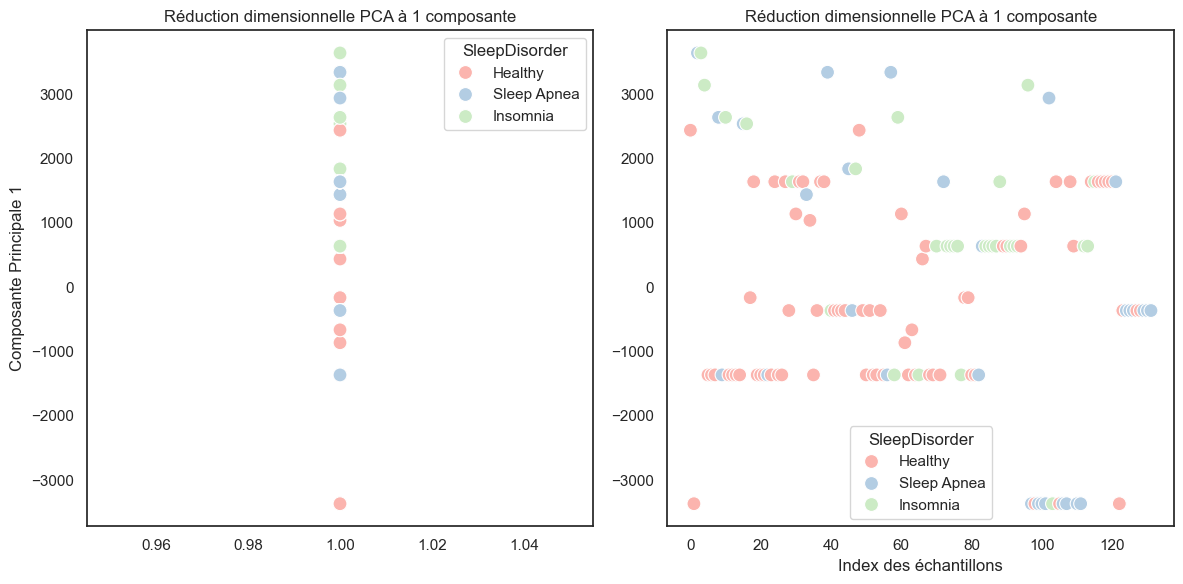

In [73]:
# Supposons que 'df' soit votre DataFrame
X = df[["Age", "SleepDuration", "PhysicalActivityLevel", "StressLevel", "QualitySleep",
                 "HeartRate", "DailySteps"]]  # Caractéristiques (toutes les colonnes sauf la dernière)
y = df["SleepDisorder"]  # Colonne cible
 # Appliquer PCA (1 composante)
acp1 = PCA(n_components=1, random_state=42).fit_transform(X)

# Créer un DataFrame avec les composantes principales
acp_df = pd.DataFrame(acp1, columns=['Composante Principale 1'])
acp_df['HasSleepDisorder'] = y

# Définir le style Seaborn avec un thème bleu (par exemple, 'whitegrid')
sns.set(style="white")  # Supprimer les lignes de la grille en utilisant le style 'white'

# Créer des sous-graphes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Graphe 1 : Nuage de points avec une valeur constante sur l'axe des X pour chaque échantillon
sns.scatterplot(x=np.ones(len(acp1)), y=acp1[:, 0], hue=y, palette="Pastel1", ax=axes[0], s=100)
axes[0].set_title('Réduction dimensionnelle PCA à 1 composante')
axes[0].set_ylabel('Composante Principale 1')

# Graphe 2 : Nuage de points avec l'index des échantillons sur l'axe des X
sns.scatterplot(x=range(len(acp1)), y=acp1[:, 0], hue=y, palette="Pastel1", ax=axes[1], s=100)
axes[1].set_title('Réduction dimensionnelle PCA à 1 composante')
axes[1].set_xlabel('Index des échantillons')


# Afficher le graphique
plt.tight_layout()  # Ajuster l'espacement entre les sous-graphes
plt.show()


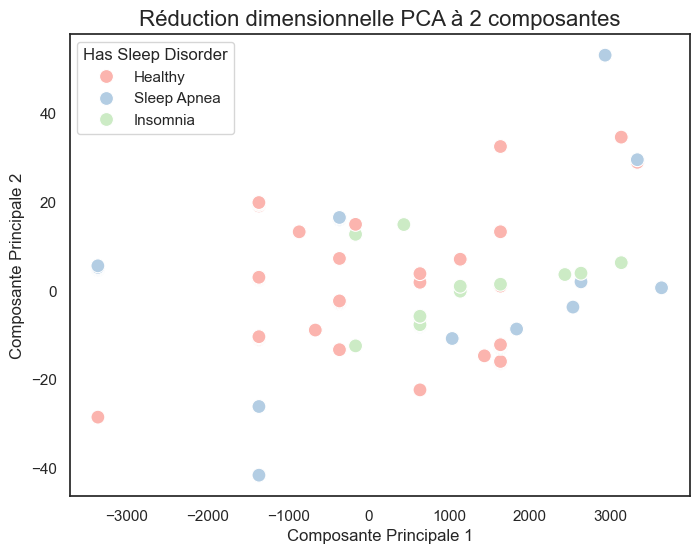

In [74]:
# Apply PCA (2 components)
acp = PCA(n_components=2, random_state=42).fit_transform(X)

# Create a DataFrame with PCA components
acp_df = pd.DataFrame(acp, columns=['Principal Component 1', 'Principal Component 2'])
acp_df['HasSleepDisorder'] = y

# Set Seaborn style to a blue theme (e.g., 'darkgrid')

# Create the Seaborn scatterplot with blue color palette
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='HasSleepDisorder',
                palette="Pastel1", data=acp_df, s=100)

# Customize the plot with titles and labels
plt.title('Réduction dimensionnelle PCA à 2 composantes', fontsize=16)
plt.xlabel('Composante Principale 1', fontsize=12)
plt.ylabel('Composante Principale 2', fontsize=12)
plt.legend(title='Has Sleep Disorder', loc='best')

# Display the plot
plt.show()

# Préprocessing

In [82]:
# On sépare la tension en pression systolique et pression diastolique
for i in range(1,len(df)+1):
    pressure_list = df.loc[i,"BloodPressure"].split(sep='/')
    df.loc[i,"BloodPressureSystolic"] = int(pressure_list[0])
    df.loc[i,"BloodPressureDiastolic"] = int(pressure_list[1])
df.drop(columns="BloodPressure", inplace=True)

# On crée la liste des noms de variables quantitatives et qualitatives ordinales
quantitatives = ["Age", "SleepDuration", "PhysicalActivityLevel", "StressLevel", "QualitySleep",
                 "HeartRate", "DailySteps", "BloodPressureSystolic", "BloodPressureDiastolic"]

# On prépare une nouvelle colonne binaire pour les sujets sains et qui présentent un trouble du sommeil
encoding = {"Healthy": "Healthy", "Insomnia": "Unhealthy", "Sleep Apnea": "Unhealthy"} # 3 labels : sain, insomnie, apnée du sommeil
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)

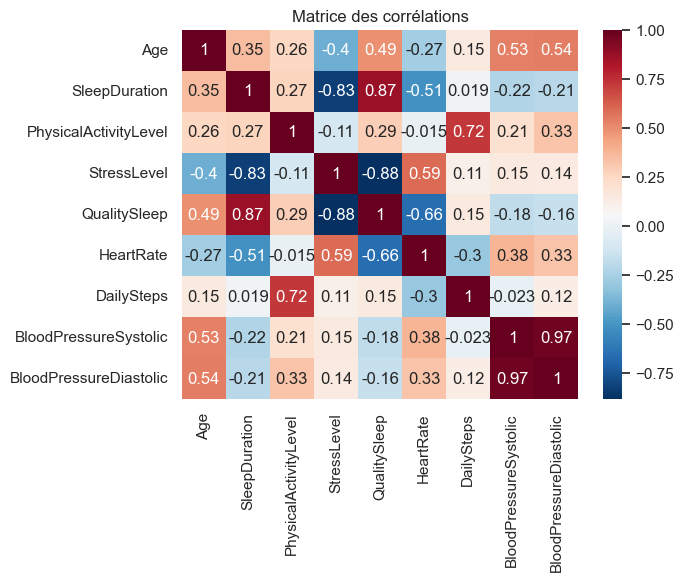

In [83]:
# On crée la matrice des corrélation pour les variables quantitatives et qualitatives ordinales
sns.heatmap(df[quantitatives].corr(), annot=True, cmap="RdBu_r")
plt.title("Matrice des corrélations")
plt.show()
# plt.savefig()

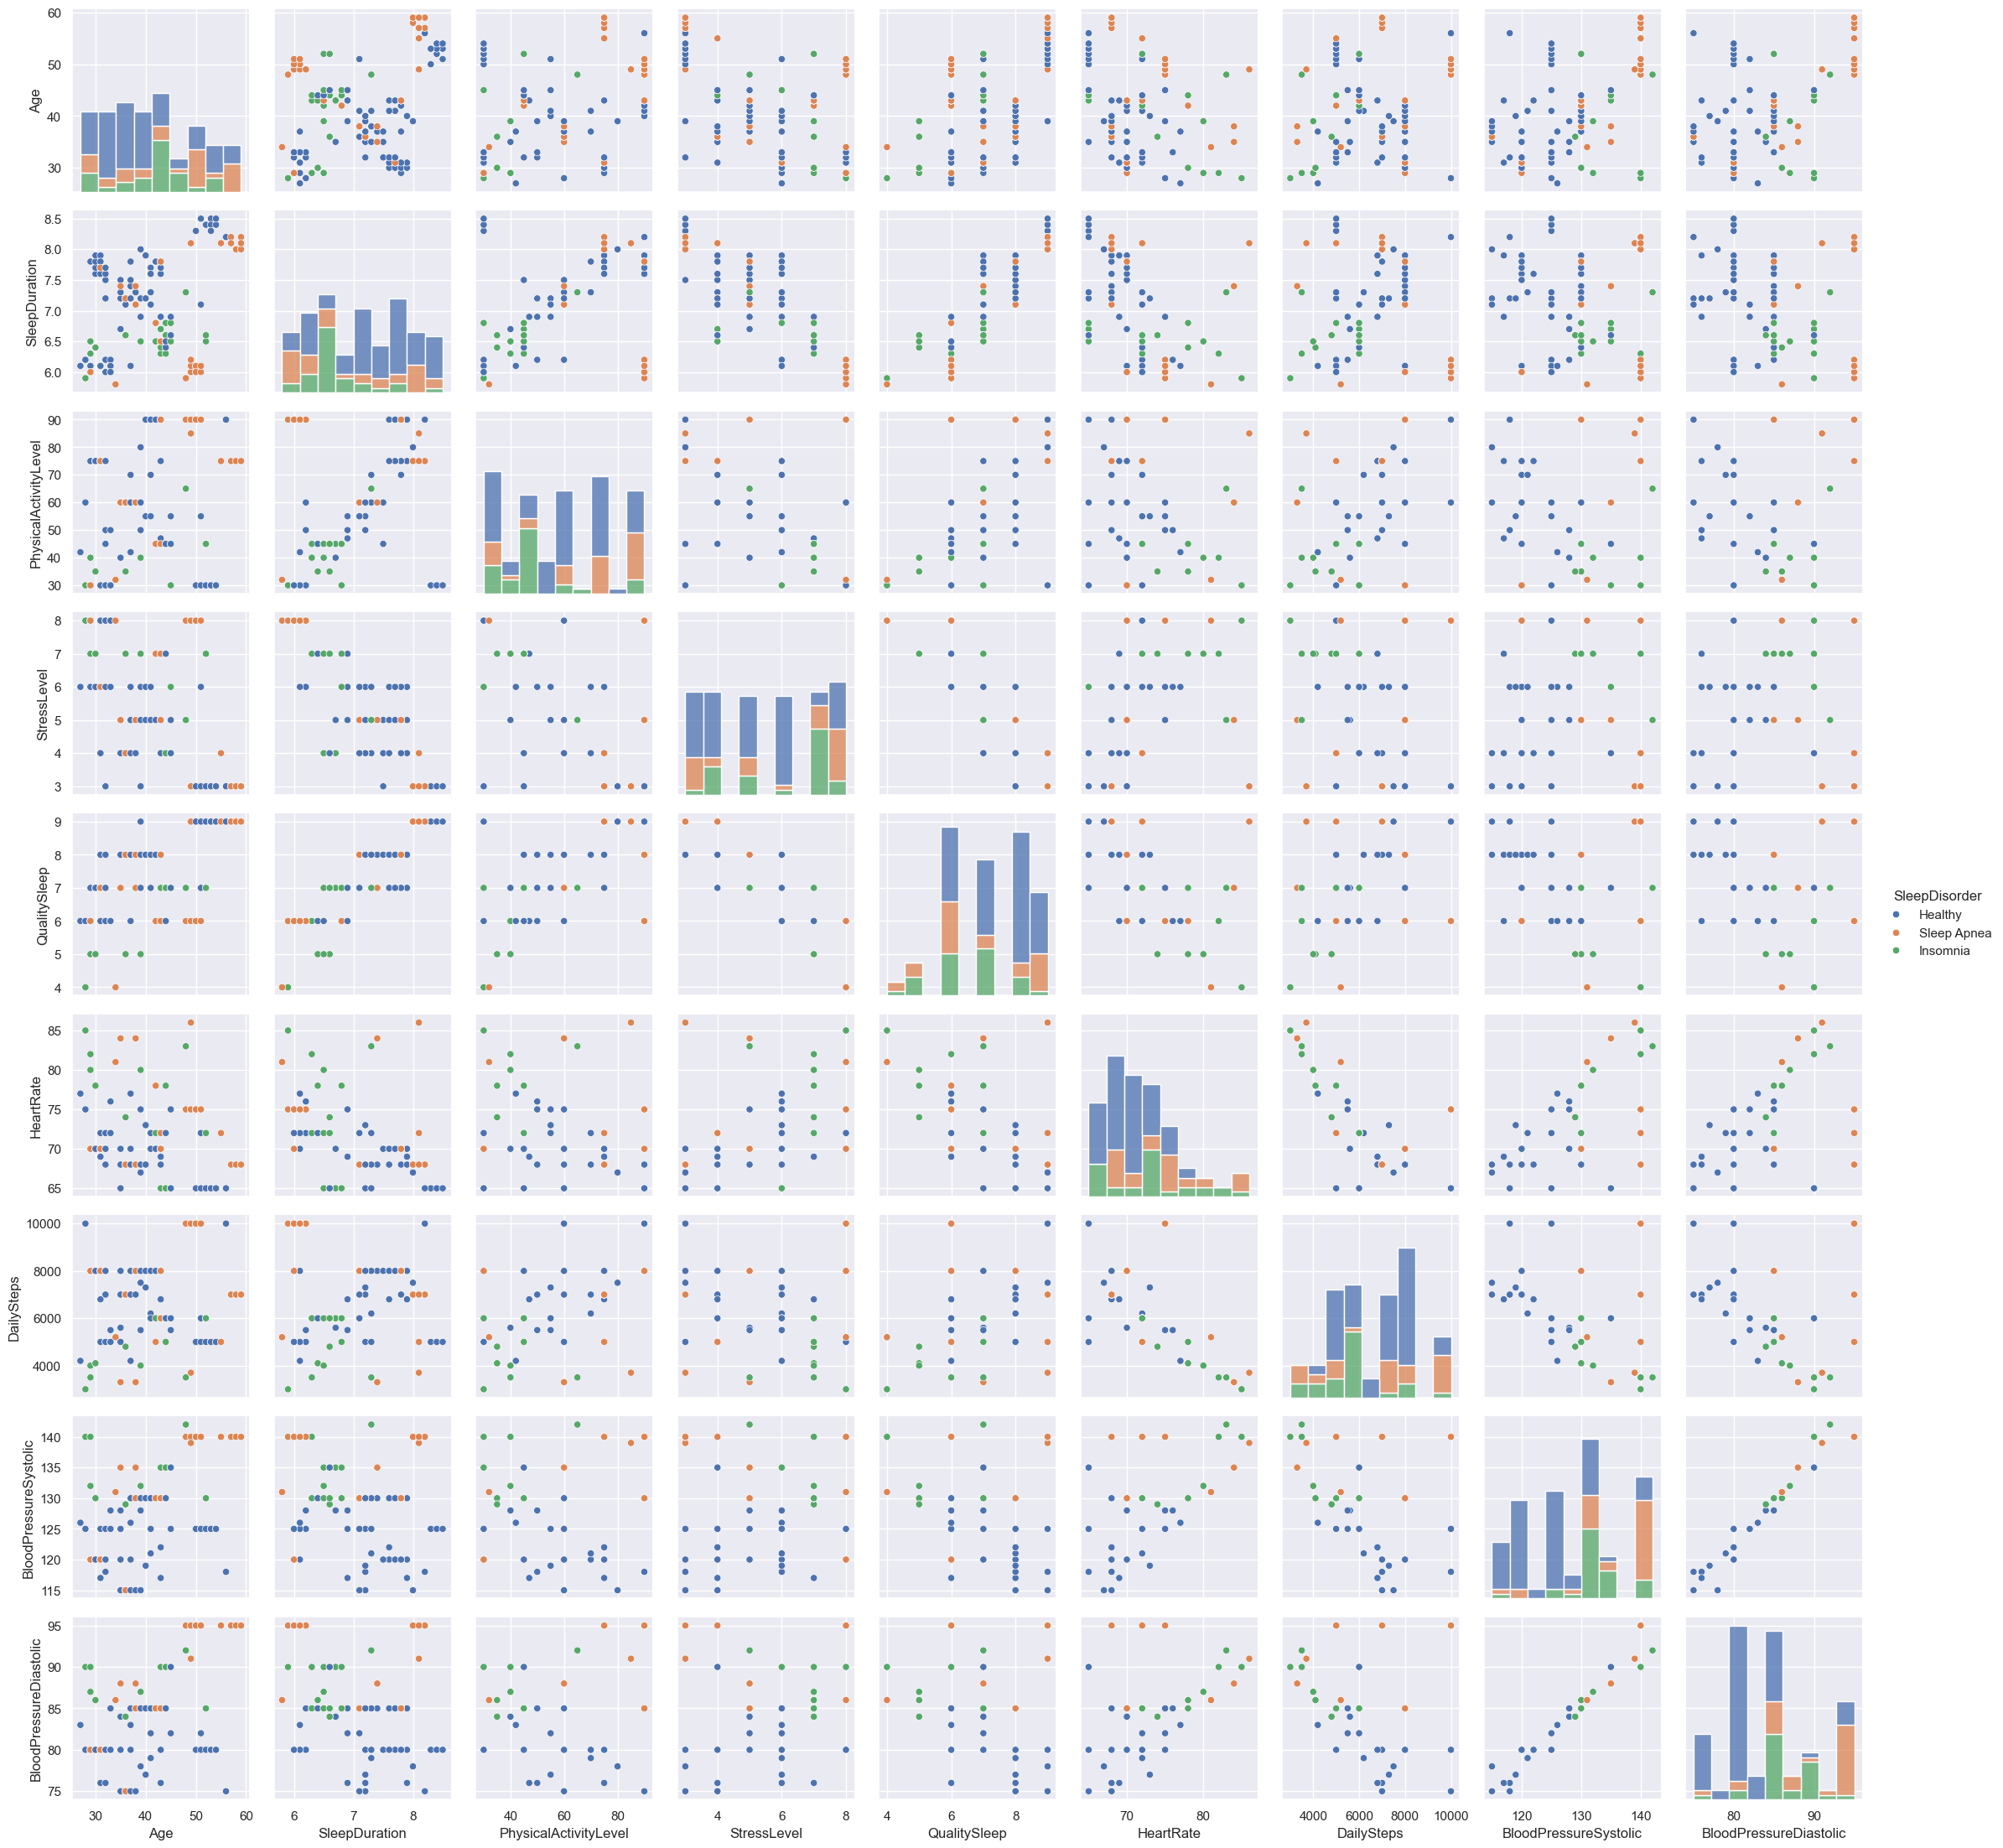

In [84]:
sns.set_theme()
g = sns.PairGrid(df[quantitatives+["SleepDisorder"]], hue="SleepDisorder")
g.map_diag(sns.histplot, multiple="stack")
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

In [53]:
# Encodage de la variable à expliquer SleepDisorder
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 2} # 3 labels : sain, insomnie, apnée du sommeil
df["SleepDisorderEncoded"] = df["SleepDisorder"].map(encoding)
encoding = {"Healthy": 0, "Insomnia": 1, "Sleep Apnea": 1} # 2 labels : avec vs sans trouble
df["HasSleepDisorder"] = df["SleepDisorder"].map(encoding)
df.drop(columns="SleepDisorder", inplace=True)

# Encodage des variables catégorielles
def OneHot(df, columns, except_one=False):
    '''
    One Hot Encoding pour une variable catégorielle.
    '''
    if except_one:
        for column in columns:
            for iter in df[column].unique()[:-1]:
                name = iter.replace(" ", "")
                df[name] = 0
                df.loc[df[column]==iter,name] = 1
    else:
        for column in columns:
            for iter in df[column].unique():
                name = iter.replace(" ", "")
                df[name] = 0
                df.loc[df[column]==iter,name] = 1
        
    df = df.drop(columns=columns, inplace=False)

    return df

df_all_encoded = OneHot(df, ["Gender", "Occupation", "BMI_Category"])
df_minimal_encoded = OneHot(df, ["Gender", "Occupation", "BMI_Category"], except_one=True)

# Découpage en train/test
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_all_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"]), 
                                                    df_all_encoded[["SleepDisorderEncoded","HasSleepDisorder"]], random_state=42,
                                                    stratify=df["SleepDisorderEncoded"])

X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(df_all_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"]), 
                                                    df_all_encoded[["SleepDisorderEncoded","HasSleepDisorder"]], random_state=42,
                                                    stratify=df["SleepDisorderEncoded"])

# Full set notamment pour entraîner la forêt 
X_full_set_all = df_all_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"])
Y_full_set_all = df_all_encoded[["SleepDisorderEncoded","HasSleepDisorder"]]
X_full_set_minimal = df_minimal_encoded.drop(columns=["SleepDisorderEncoded", "HasSleepDisorder"])
Y_full_set_minimal = df_minimal_encoded[["SleepDisorderEncoded","HasSleepDisorder"]]

# Fonction utilisée

In [19]:
def Matrice_Var(model):
    model = model
    pred_train = model.predict(X_train_all)

    # Calculer un array de proba de prédiction pour la classe 1 et mettre un seuil pour customiser le modèle
    y_prob = model.predict_proba(X_test_all)[:, 1]
    pred_test = (y_prob > 0.5).astype(int)
    print("Acccuracy : ", len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))

    # Matrice de confusion
    cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
    
    # Créer subplot pour la Matrice de Confusion et la courbe ROC 
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plotter Matrice de Confusion
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title("Matrice de Confusion")

    # Générer un courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test_all["HasSleepDisorder"], y_prob)

    # Computer Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")

    # Plot la courbe ROC
    axes[1].plot(fpr, tpr, color="blue", lw=2, label=f"Courbe ROC (AUC = {roc_auc:.2f})")
    axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1.5, label="Pile ou Face")
    axes[1].set_title("Courbe ROC")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")
    axes[1].grid(True)

def Feature_imp(model):
    # Extraire les features importances
    feature_importances = model.feature_importances_

    # Create a DataFrame for feature importances
    features = pd.DataFrame({
        'Feature': X_train_all.columns,
        'Importance': feature_importances
    })

    # Selectionner le top 10 features les plus importants
    top_features = features.sort_values(by='Importance', ascending=False).head(10)

    # Plot les 10 features plus importants
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')
    plt.title('Top 10 Variables Importantes')
    plt.xlabel('Variables Importantes')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [20]:
class mm_scaler:
    def __init__(self):
        self.grades = None
        self.quantitatives = None
        self.mini = {}
        self.maxi = {}

    def fit(self, data, quantitatives, grades):
        self.grades = grades
        self.quantitatives = quantitatives

        for column in quantitatives:
            self.mini[column] = min(data[column])*0.9
            self.maxi[column] = max(data[column])*1.1
        
    def transform(self, data):
        df_copy = data.copy()

        # On scale les colonnes quantitatives
        for column in self.quantitatives:
            df_copy[column] = (df_copy[column] - self.mini[column]) / \
                              (self.maxi[column]-self.mini[column])
        
        # On scale les notes
        df_copy[self.grades] = df_copy[self.grades]/10
        
        return df_copy
    
    def transform_inverse(self, data):
        df_copy = data.copy()

        # On retransforme les données quantitatives
        for column in self.quantitatives:
            df_copy[column] = df_copy[column]*(self.maxi[column]-self.mini[column]) + \
                              self.mini[column]
        
        # On retransforme les notes
        df_copy[self.grades] = df_copy[self.grades]*10
        
        return df_copy

# Modèles

## Vecteur de support machine

0.8484848484848485
0.7878787878787878


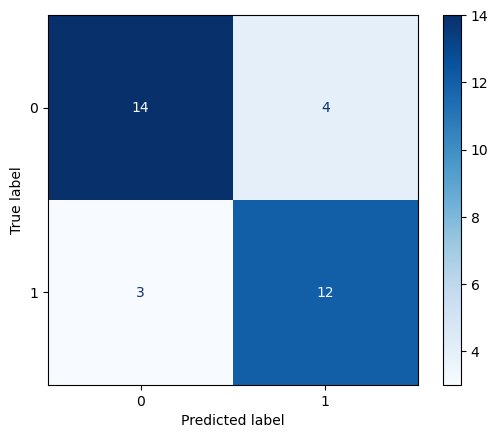

In [114]:
SVM_HAS = SVC(kernel="linear", max_iter=-1,C=3, random_state=42).fit(X_train_all_scaled.drop(columns=["BloodPressureDiastolic"]), y_train_minimal["HasSleepDisorder"])
pred_train = SVM_HAS.predict(X_train_all_scaled.drop(columns=["BloodPressureDiastolic"]))
pred_test = SVM_HAS.predict(my_scaler.transform(X_test_all).drop(columns = ["BloodPressureDiastolic"]))
print(len(y_train_all[y_train_all["HasSleepDisorder"]==pred_train])/len(y_train_all))
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)

## L'arbre de décision

### L'arbre de décision simple

0.9090909090909091
0.7272727272727273


Text(0.5, 1.0, 'Matrice de Confusion')

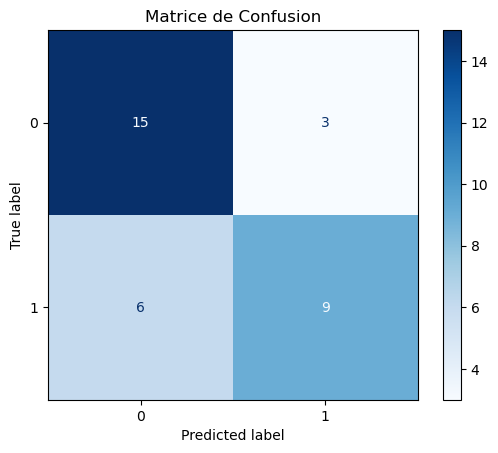

In [14]:
TREE_HAS = DecisionTreeClassifier(random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
pred_train = TREE_HAS.predict(X_train_all)
pred_test = TREE_HAS.predict(X_test_all)
print(len(y_train_all[y_train_all["HasSleepDisorder"]==pred_train])/len(y_train_all))
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")

### L'arbre de décision simple

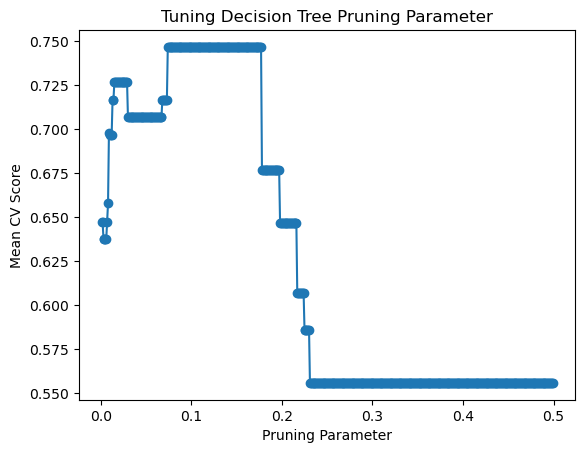

In [11]:
# Define the range of pruning parameter values to test
pruning_params = np.arange(0.001, 0.5, 0.001)

# Store the mean cross-validation scores for each pruning parameter value
cv_scores = []

# Perform cross-validation for each pruning parameter value
for param in pruning_params:
    # Create a decision tree classifier with the specified pruning parameter
    clf = DecisionTreeClassifier(ccp_alpha=param, random_state=42)

    # Perform cross-validation and calculate the mean score, which is the coefficient of determination (R2) in regression
    scores = cross_val_score(clf, X_train_all, y_train_all["HasSleepDisorder"], cv=5)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

# Plot the mean cross-validation scores as a function of pruning parameter values
plt.plot(pruning_params, cv_scores, marker='o')
plt.xlabel('Pruning Parameter')
plt.ylabel('Mean CV Score')
plt.title('Tuning Decision Tree Pruning Parameter')
plt.show()

In [30]:
TREE_HAS = DecisionTreeClassifier(ccp_alpha=0.1, random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
pred_train = TREE_HAS.predict(X_train_all)
pred_test = TREE_HAS.predict(X_test_all)
print(len(y_train_all[y_train_all["HasSleepDisorder"]==pred_train])/len(y_train_all))
print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test)

0.8080808080808081
0.8484848484848485


Acccuracy :  0.8484848484848485
AUC: 0.85


/var/folders/56/_dpbkklj7cbfxf4fl0w7bp380000gp/T/ipykernel_63159/3424797433.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')


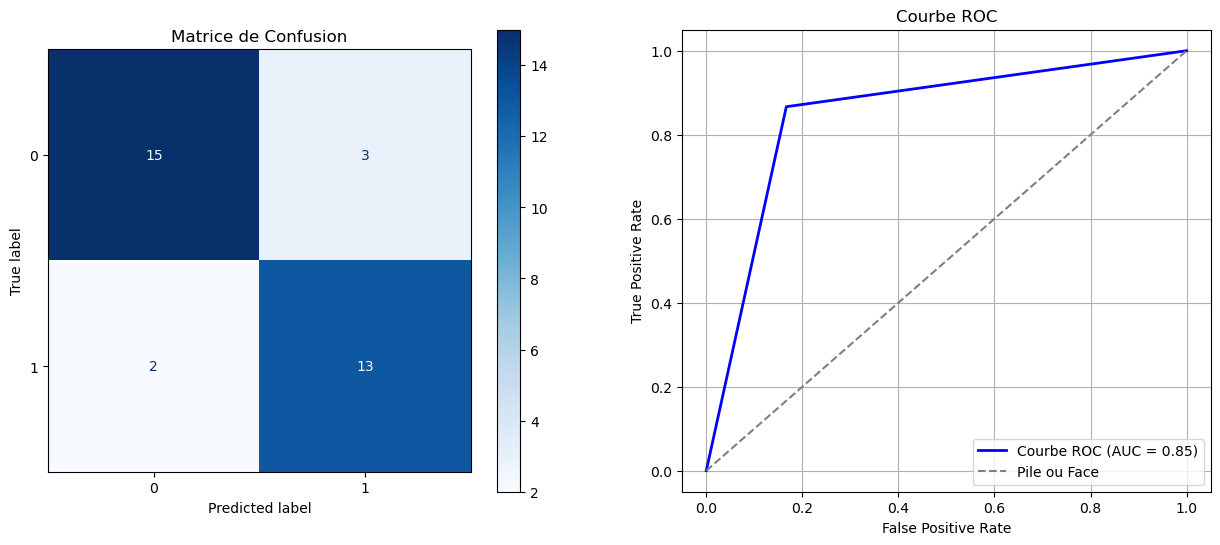

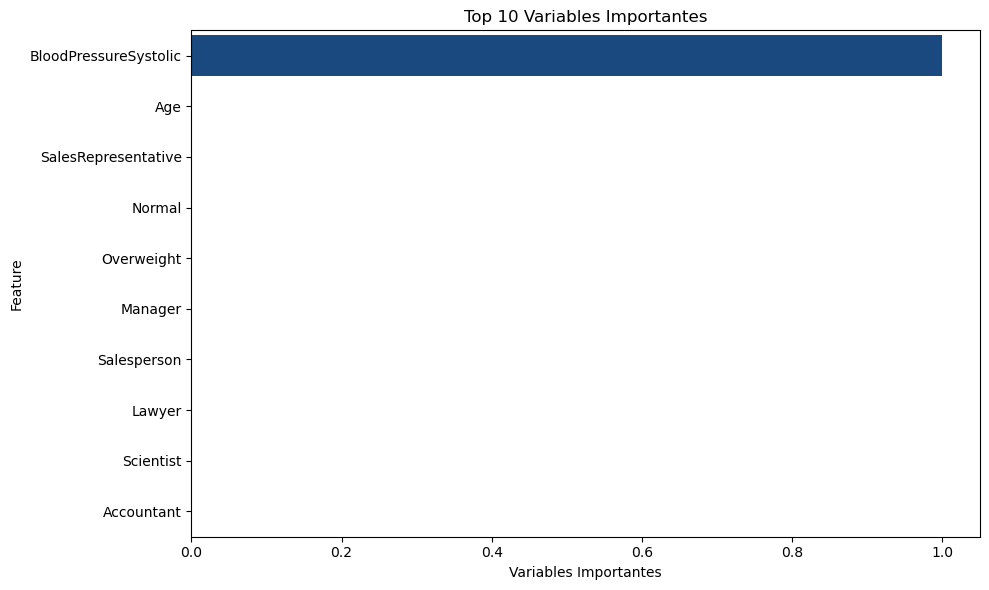

In [50]:
Matrice_Var(DecisionTreeClassifier(ccp_alpha=0.1, random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"]))
Feature_imp(DecisionTreeClassifier(ccp_alpha=0.1, random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"]))

## Fôret Aléatoire 

In [21]:
FOREST_MULTI = RandomForestClassifier(n_estimators=100, max_features=3, min_samples_split=10, criterion = "entropy",
                                      random_state=42)
cv_scores = cross_val_score(FOREST_MULTI, X_train_all, y_train_all["HasSleepDisorder"], cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} ")

CV Accuracy: 0.8174 


Estimer modèle Foret Aléatoire avec OOB 

In [22]:
FOREST_MULTI = RandomForestClassifier(n_estimators=90, max_features=1, min_samples_split=12, oob_score=True, 
                                      criterion = "entropy", random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"])
# df_all_encoded
# Accéder au score OOB
oob_accuracy = FOREST_MULTI.oob_score_
print(f'Accuracy OOB : {oob_accuracy:.4f}')

Accuracy OOB : 0.8283


Gridsearch

In [36]:
rf = RandomForestClassifier(criterion = "entropy",random_state=42)
param_grid = {
    'n_estimators': [90,100,110,120],         
    'max_features' : [1,2,3,4,5], 
    'min_samples_split' : [3,4,5,67,8,9,10,11,12], 
    'min_impurity_decrease' : np.arange(0.1, 0.9, 0.1)
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                                    
    scoring='accuracy',     
)

grid_search.fit(X_train_all, y_train_all["HasSleepDisorder"])

# Meilleurs Paramtres trouvées par GridSearch
print("Best Parameters:", grid_search.best_params_)

# Meilleurs accuracy 
print("Best accuracy", grid_search.best_score_)


Best Parameters: {'max_features': 3, 'min_impurity_decrease': 0.2, 'min_samples_split': 3, 'n_estimators': 110}
Best accuracy 0.8478947368421054


In [37]:
my_model_rf = grid_search.best_estimator_

Acccuracy :  0.8484848484848485
AUC: 0.83


/var/folders/56/_dpbkklj7cbfxf4fl0w7bp380000gp/T/ipykernel_63159/3424797433.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')


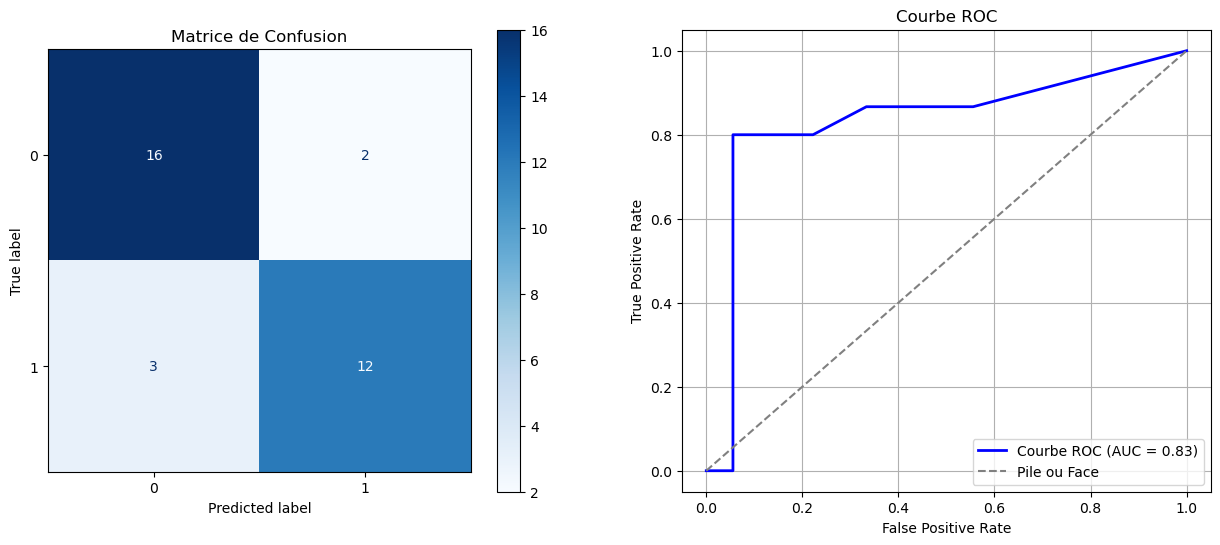

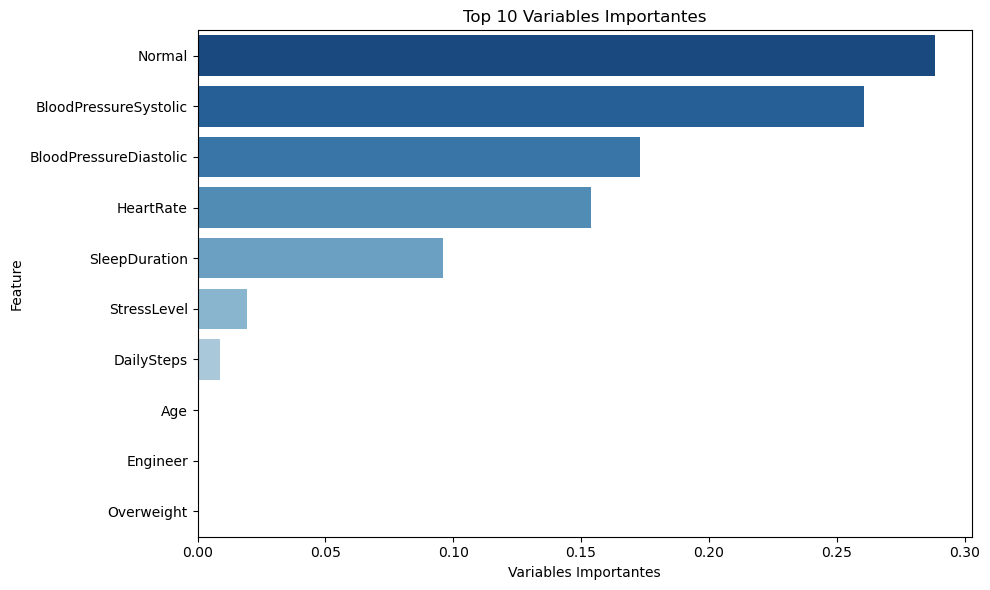

In [54]:
Matrice_Var(my_model_rf.fit(X_train_all, y_train_all["HasSleepDisorder"]))
Feature_imp(my_model_rf.fit(X_train_all, y_train_all["HasSleepDisorder"]))

Acccuracy :  0.8787878787878788
AUC: 0.84


/var/folders/56/_dpbkklj7cbfxf4fl0w7bp380000gp/T/ipykernel_63159/3424797433.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')


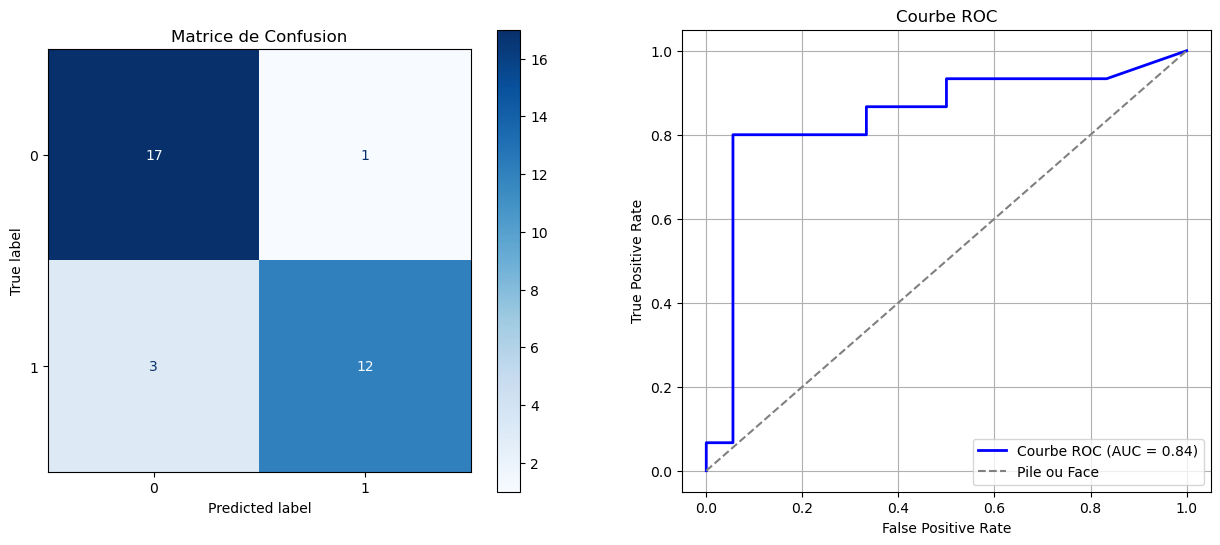

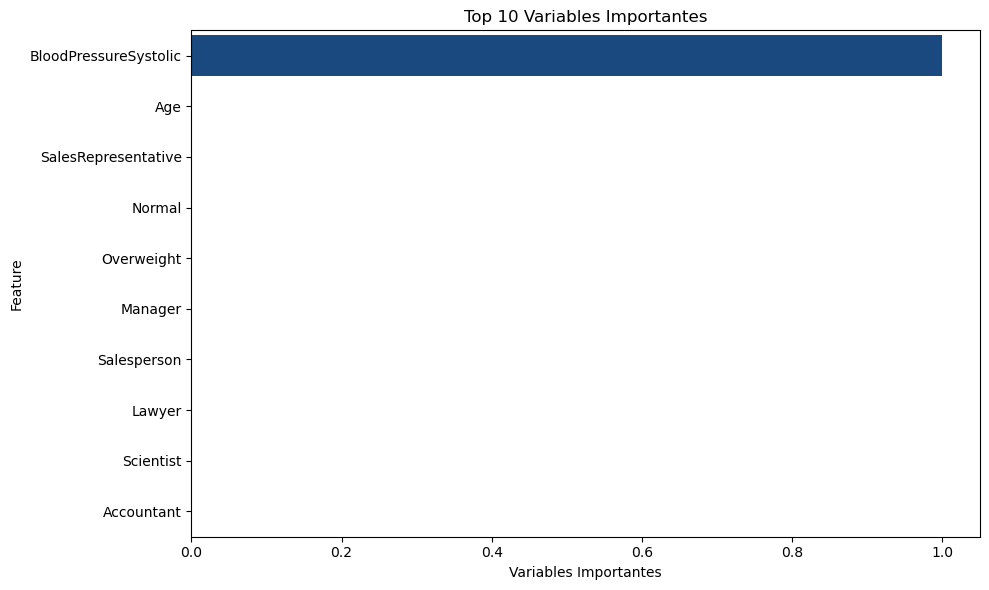

In [57]:
Matrice_Var(RandomForestClassifier(n_estimators=100, max_features=3, min_samples_split=10,  criterion = "entropy", random_state=42
                                       ).fit(X_train_all, y_train_all["HasSleepDisorder"]))
Feature_imp(DecisionTreeClassifier(ccp_alpha=0.1, random_state=42).fit(X_train_all, y_train_all["HasSleepDisorder"]))

## Gradient boosting

In [40]:
# Modèle de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Grille d'hyperparamètres
gb_param_grid = {
    'n_estimators': [20, 30, 50, 100, 200],
    'learning_rate': [0.005, 0.01, 0.1, 0.2],
    'max_depth': [1, 2, 3, 5, 7, None],
    'subsample': [0.6, 0.8, 1.0],   
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV pour Gradient Boosting
gb_grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    scoring='accuracy',
    cv=5,

)
gb_grid_search.fit(X_train_all, y_train_all["HasSleepDisorder"])

print("Meilleurs paramètres Gradient Boosting:", gb_grid_search.best_params_)
print("Meilleure précision Gradient Boosting:", gb_grid_search.best_score_)

Meilleurs paramètres Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.6}
Meilleure précision Gradient Boosting: 0.8478947368421054


In [46]:
my_model_gb = gb_grid_search.best_estimator_

Acccuracy :  0.8787878787878788
AUC: 0.84


/var/folders/56/_dpbkklj7cbfxf4fl0w7bp380000gp/T/ipykernel_63159/3424797433.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='Blues_r')


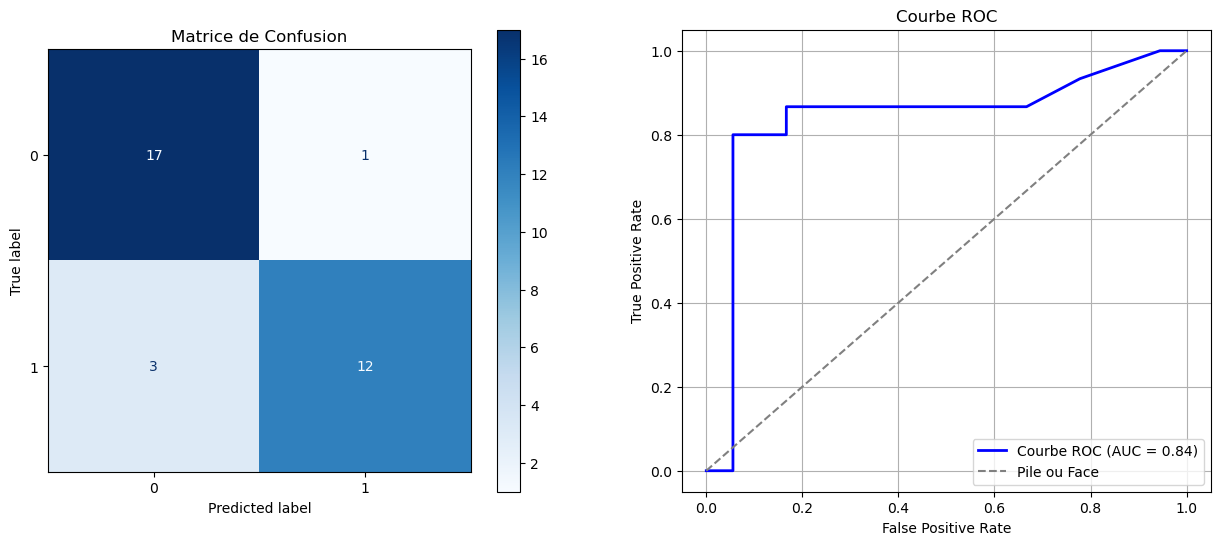

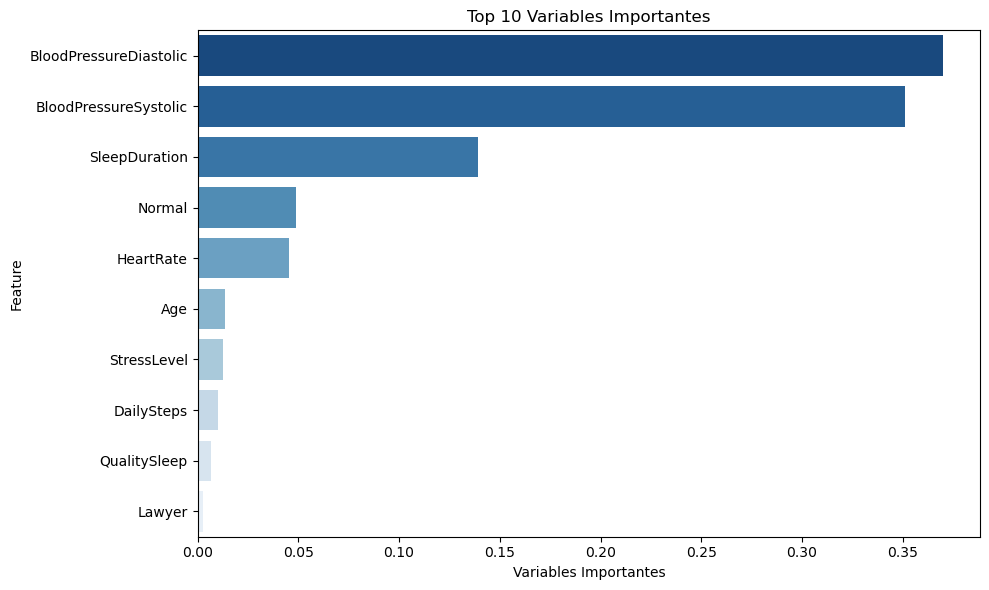

In [53]:
BOOSTING_MULTI = my_model_gb.fit(X_train_all, y_train_all["HasSleepDisorder"])
Matrice_Var(BOOSTING_MULTI)
Feature_imp(BOOSTING_MULTI)

## Perceptron multicouche

In [61]:
my_scaler = mm_scaler()
quantitatives_bis = [item for item in quantitatives if item not in ["QualitySleep", "StressLevel"]]
my_scaler.fit(X_train_all,quantitatives_bis, ["QualitySleep", "StressLevel"])
X_train_all_scaled = my_scaler.transform(X_train_all)
X_test_all_scaled = my_scaler.transform(X_test_all)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4875 - loss: 1.1532 - val_accuracy: 0.3500 - val_loss: 1.1525
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5290 - loss: 1.1351 - val_accuracy: 0.3500 - val_loss: 1.1459
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5275 - loss: 1.1260 - val_accuracy: 0.3500 - val_loss: 1.1407
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5222 - loss: 1.1291 - val_accuracy: 0.4000 - val_loss: 1.1358
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5363 - loss: 1.1225 - val_accuracy: 0.5500 - val_loss: 1.1310
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5670 - loss: 1.1237 - val_accuracy: 0.5500 - val_loss: 1.1262
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5017 - loss: 1.1291 - val_accuracy: 0.7000 - val_loss: 1.1213
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5661 - loss: 1.1103 - val_accuracy: 0.7500 - val_loss: 1.1160
Epoch 9/10


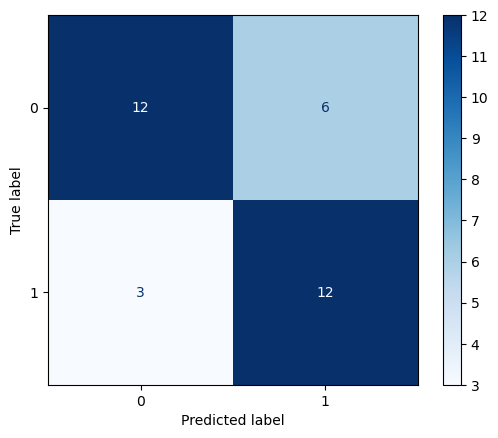

In [137]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Définition du modèle
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_all_scaled.shape[1],), kernel_regularizer=l2(0.01)),  # L2 régularisation  
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),   
    Dense(32, activation='relu'),   
    Dropout(0.3),   
    Dense(1, activation='sigmoid')  # Couche de sortie (1 neurones pour classification binaire avec softmax)
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model.fit(X_train_all_scaled, y_train_all["HasSleepDisorder"], epochs=10, batch_size=32, validation_split=0.2)

# Prédictions sur le jeu de test
pred_test = model.predict(X_test_all_scaled)
pred_test_classes = (pred_test > 0.5).astype(int).flatten()  # Convertir en classes prédictes

print(len(y_test_all[y_test_all["HasSleepDisorder"]==pred_test_classes])/len(y_test_all))
cm = confusion_matrix(y_test_all["HasSleepDisorder"], pred_test_classes)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
